In [1]:
import awkward as ak
from ak_helpers import *

import numpy as np
import cupy as cp
import numba.cuda

# Pythonic GPU parallelism for HEP with `cuda.compute`

## Why this talk

Awkward Arrays is fast on GPUs! Today, this is implemented using **raw CUDA C++ kernels**

<img src="images/awkward-cuda-kernels.png" width="60%">


Maintaining and extending this functionality requires **significant CUDA expertise and C++ interop infrastructure**

<img src="images/awkward-reduce-kernel.png" width="60%">


Using raw CUDA kernels to implement individual ops **leaves a lot of performance on the table**!

`cuda.compute` can help:

**simplify** Awkward-on-GPUs by replacing CUDA kernels with pure Python

**speed up** Awkward-on-GPUs by enabling fusion of operations

**enable more of the HEP community** to contribute!

## Structure of this talk

GPUs and the challenges of programming them

Performance study of an Awkward-on-GPU example

Overview of `cuda.compute`

Rewriting the example using `cuda.compute` + Awkward (speedup!)

Takeaways & future direction

## Section 1: GPUs and programming them

### CPU v/s GPU

CPUs and GPUs are both general-purpose processors optimized for different workloads:

<img src="images/cpu-gpu-1.png" width="50%">

| CPUs                                     | GPUs                                 |
| ---------------------------------------- | ------------------------------------ |
| Optimized for **serial work**            | Optimized for **parallel work**      |
| **Few, powerful cores**                  | **Thousands of lightweight threads** |
| **Low latency**, lower memory throughput | **High throughput**, higher latency  |


### When GPUs outperform CPUs

**High parallelism / large data sizes**: GPUs can exploit thousands of threads, while CPUs typically run only a few dozen in parallel

**High computational intensity**:
When the ratio of math per byte loaded from memory is high GPUs can keep threads busy instead of waiting on memory

**Minimizing kernel launch + data transfer costs**:
Launching kernels or transferring data to GPU memory are expensive operations. Minimizing/amortizing their costs help get better speedup with GPUs.

**Using specialized GPU units** (e.g., Tensor Cores) when available can deliver order-of-magnitude gains vs CPUs.

### Programming GPUs

Writing optimized GPU code with all the above considerations in mind is challenging. Here is an "optimized" CUDA kernel for performing reduction: 

```c++
template <unsigned int blockSize>
__device__ void warpReduce(volatile int *sdata, unsigned int tid) {
  if (blockSize >= 64) sdata[tid] += sdata[tid + 32];
  if (blockSize >= 32) sdata[tid] += sdata[tid + 16];
  if (blockSize >= 16) sdata[tid] += sdata[tid + 8];
  if (blockSize >= 8) sdata[tid] += sdata[tid + 4];
  if (blockSize >= 4) sdata[tid] += sdata[tid + 2];
  if (blockSize >= 2) sdata[tid] += sdata[tid + 1];
}
template <unsigned int blockSize>
__global__ void reduce6(int *g_idata, int *g_odata, unsigned int n) {
  extern __shared__ int sdata[];
  unsigned int tid = threadIdx.x;
  unsigned int i = blockIdx.x*(blockSize*2) + tid;
  unsigned int gridSize = blockSize*2*gridDim.x;
  sdata[tid] = 0;
  while (i < n) { sdata[tid] += g_idata[i] + g_idata[i+blockSize]; i += gridSize; }
  __syncthreads();
  if (blockSize >= 512) { if (tid < 256) { sdata[tid] += sdata[tid + 256]; } __syncthreads(); }
  if (blockSize >= 256) { if (tid < 128) { sdata[tid] += sdata[tid + 128]; } __syncthreads(); }
  if (blockSize >= 128) { if (tid < 64) { sdata[tid] += sdata[tid + 64]; } __syncthreads(); }
  if (tid < 32) warpReduce(sdata, tid);
  if (tid == 0) g_odata[blockIdx.x] = sdata[0]
}
```

### Use Libraries

CUDA libraries hide the complexity of kernel development and provide speed-of-light performance

For example, reduction in C++ using the [Thrust](https://nvidia.github.io/cccl/thrust) and( [CUB](https://nvidia.github.io/cccl/cub/api_docs/device_wide.html#device-module) library is just:

```c++
auto op     = cuda::std::plus{};
auto input  = thrust::device_vector<float>{0.0f, 1.0f, 2.0f, 3.0f};
auto output = thrust::device_vector<float>(1);
auto init   = 0.0f;

auto error = cub::DeviceReduce::Reduce(input.begin(), output.begin(), input.size(), op, init);
```

**Python packages** (CuPy, PyTorch, etc.) build upon CUDA libraries like CUB to implement core GPU ops:

<img src="images/cccl-everywhere.png" width="75%">

### Where does `cuda.compute` fit?

<img src="images/cuda-cccl.png" width="50%">

`cuda.compute` provides direct access to the CUDA Core Compute Libraries like CUB

Enables building and extending Python GPU libraries using battle-tested, speed-of-light primitives instead of writing/maintaining bespoke CUDA kernels

## Section 2: Performance study: Awkward on GPU

Now, let's jump right in and execute some Python code that uses CUDA.

We'll use the [dimuon search example](https://awkward-array.org/doc/main/getting-started/jagged-ragged-awkward-arrays.html#application-to-dimuons) from the Awkward Array docs.


In [2]:
import awkward as ak
import numpy as np
import cupy as cp
import uproot
import nvtx

file = uproot.open(
    "https://github.com/jpivarski-talks/2023-12-18-hsf-india-tutorial-bhubaneswar/raw/main/data/SMHiggsToZZTo4L.root"
)
tree = file["Events"]
arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/")
muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }
)
muons = ak.concatenate([muons] * 100)  # artificially increase data size

pairs = ak.combinations(muons, 2)

mu1, mu2 = ak.unzip(pairs)

pairs

<Array [[({...}, {...}), ..., (..., ...)], ...] type='29997300 * var * ({pt...'>

First, let's perform the computation of the invariant mass on the CPU:

In [3]:
%%timeit -n 2 -r 2
# benchmark run
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)

639 ms ± 976 μs per loop (mean ± std. dev. of 2 runs, 2 loops each)


Now let's try on the GPU:

In [4]:
pairs = ak.to_backend(pairs, "cuda")
mu1, mu2 = ak.unzip(pairs)

In [5]:
%%timeit -n 10 -r 10
# benchmark run
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)
cp.cuda.Device().synchronize()

The slowest run took 7.65 times longer than the fastest. This could mean that an intermediate result is being cached.
71.6 ms ± 85.7 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


It's _way_ faster on the GPU. But what's going underneath? For this section you'll have to bear with me a bit as I do some magic to profile this code.

In [6]:
# %load mass_awkward.py

import awkward as ak
import numpy as np
import cupy as cp
import uproot
import nvtx

file = uproot.open(
    "https://github.com/jpivarski-talks/2023-12-18-hsf-india-tutorial-bhubaneswar/raw/main/data/SMHiggsToZZTo4L.root"
)
tree = file["Events"]
arrays = tree.arrays(filter_name="/Muon_(pt|eta|phi|charge)/")
muons = ak.zip(
    {
        "pt": arrays["Muon_pt"],
        "eta": arrays["Muon_eta"],
        "phi": arrays["Muon_phi"],
        "charge": arrays["Muon_charge"],
    }
)
muons = ak.concatenate([muons] * 100)  # artificially increase data size

pairs = ak.combinations(muons, 2)
pairs = ak.to_backend(pairs, "cuda")

mu1, mu2 = ak.unzip(pairs)

# warmup run
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)
cp.cuda.Device().synchronize()

# benchmark run:
with nvtx.annotate("mass_calculation"):
    mass = np.sqrt(
        2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
    )
    cp.cuda.Device().synchronize()


The command below runs the script `mass_awkward.py` through the [Nsight Systems](https://docs.nvidia.com/nsight-systems/UserGuide/index.html) profiler. We're only interested in the section of code that does the mass calculation, so we've annotated that section of code in the script.

In [7]:
!nsys profile \
  -t cuda,nvtx \
  --capture-range=nvtx \
  --nvtx-capture="mass_calculation" \
  --env-var=NSYS_NVTX_PROFILER_REGISTER_ONLY=0 \
  -o mass_awkward \
  --force-overwrite true \
  --export sqlite \
  python mass_awkward.py

         This may increase runtime overhead and the likelihood of false
         dependencies across CUDA Streams. If you wish to avoid this, please
         disable the feature with --cuda-event-trace=false.
Try the 'nsys status --environment' command to learn more.

Try the 'nsys status --environment' command to learn more.

Capture range started in the application.
Capture range ended in the application.
Generating '/tmp/nsys-report-6f4a.qdstrm'
[1/2] [0%                          ] mass_awkward.nsys-repProcessing events...
[1/2] [========================100%] mass_awkward.nsys-rep
[2/2] [========================100%] mass_awkward.sqlite
Generated:
	/home/ashwin/workspace/awkward-cccl/mass_awkward.nsys-rep
	/home/ashwin/workspace/awkward-cccl/mass_awkward.sqlite


We can visualize the results of profiling using [nsightful](https://github.com/brycelelbach/nsightful):

In [8]:
import nsightful

nsightful.display_nsys_sqlite_file_in_notebook('mass_awkward.sqlite')

Zoom in to the `mass_calculations` section of the profile, which is the interesting part. You'll notice that this section of code is composed of many CUDA kernels:

<img src="images/mass-awkward-timeline.png" width="100%">

<img src="images/mass-awkward-kernels.png" width="100%">

Each of these (hand-written) CUDA kernels could be replaced with much more efficient CUB/Thrust CUDA kernels.

The goal of the rest of this talk is to show you how you can use `cuda.compute` to optimize this section of the code.

## Section 3: Introduction to `cuda.compute`

`cuda.compute` provides Pythonic interface to the [device-wide primitives](https://nvidia.github.io/cccl/cub/api_docs/device_wide.html#device-module) offered by the CUB C++ library

- Provides primitive operations like `reduce`, `sort`, `scan`, `transform` that can be composed to build complex GPU computations
- Delivers hand-tuned performance, portable across GPU architectures
- Works with CuPy, PyTorch, Awkward Arrays, etc.
- ⚠️ low-level API meant for library developers/power users
- ⚠️ experimental status (v0.x)

### Example: Custom Reduction

As a first example, let's see how to use `cuda.compute` to compute the sum of the values in an array, using the [reduce_into](https://nvidia.github.io/cccl/python/compute_api.html#cuda.compute.algorithms.reduce_into) API:

First, we prepare the inputs (and outputs)

In [9]:
# input sequence, a CuPy (device) array:
d_input = cp.array([2, 3, 5, 1, 7, 6, 8, 4], dtype=np.int32)

# array which will hold the result, a CuPy (device) array of size 1:
d_output = cp.empty(1, dtype=np.int32)  

# initial value of the reduction, a NumPy (host) array of size 1
h_init = np.array([0], dtype=np.int32)  

Now, we can call `reduce_into`, which will perform the reduction. Note the use of `OpKind.PLUS` which specifies the type of binary operation to use for the reduction:

In [10]:
from cuda.compute import reduce_into, OpKind

# Perform the reduction.
reduce_into(d_input, d_output, OpKind.PLUS, len(d_input), h_init)

Verify it worked:

In [11]:
# Verify the result.
expected_output = 36
assert (d_output == expected_output).all()
result = d_output[0]
print(f"Sum reduction result: {result}")

Sum reduction result: 36


To compute the maximum value, we just change the op to `OpKind.MAXIMUM`:

In [12]:
h_init = np.array([0], dtype=np.int32)
reduce_into(d_input, d_output, OpKind.MAXIMUM, len(d_input), h_init)

expected_output = 8
assert (d_output == expected_output).all()
result = d_output[0]
print(f"Max reduction result: {result}")

Max reduction result: 8


At this point, you might be thinking:

> **_Umm, can't I just use CuPy or PyTorch to compute sum or max?_**

Of course, given a CuPy array, it's trivial to do simple reductions like `sum`, `min` or `max`:

In [13]:
d_input = cp.array([-2, 3, 5, 1, 7, -6, 8, -4], dtype=np.int32)

print(f"Sum using cp.sum: {cp.sum(d_input)}")
print(f"Max value using cp.max: {cp.max(d_input)}")
print(f"Min value using cp.min: {cp.min(d_input)}")

Sum using cp.sum: 12
Max value using cp.max: 8
Min value using cp.min: -6


The benefit of `cuda.compute` is more apparent when you want to do **custom operations**. For example, say we wanted to compute the sum of **only even values** in a sequence.

Naively, here's how to do that with CuPy:

In [14]:
d_input = cp.array([2, 3, 5, 1, 7, 6, 8, 4], dtype=np.int32)
result = (d_input[d_input % 2 == 0]).sum()
print(f"Sum of even values with CuPy: {result}")

Sum of even values with CuPy: 20


Now, let's do the same thing with `cuda.compute`. Instead of using a "built-in" operation like `PLUS` or `MAX`, we can define a custom binary operation as a Python callable: 

In [15]:
"""
Using `reduce_into()` with a custom binary operation
"""

# Define a custom binary operation for the reduction.
def sum_even_op(a, b):
    return (a if a % 2 == 0 else 0) + (b if b % 2 == 0 else 0)

d_input = cp.array([2, 3, 5, 1, 7, 6, 8, 4], dtype=np.int32)
d_output = cp.empty(1, dtype=np.int32)
h_init = np.array([0], dtype=np.int32)

# Call `reduce_into()` passing the function above for the binary operation:
reduce_into(d_input, d_output, sum_even_op, len(d_input), h_init)
result = d_output.get()[0]
print(f"Sum of even values with `cuda.compute`: {result}")

Sum of even values with `cuda.compute`: 20


We got the same result using `cuda.compute`, but we had to write significantly more code. Is it worth it? Below is a small benchmarking script comparing timings for a range of input sizes:

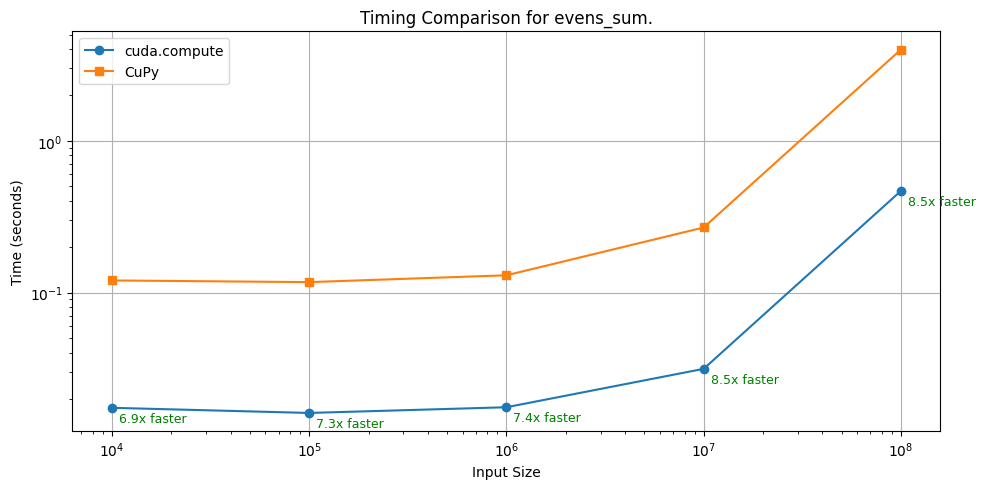

In [16]:
"""
Compare the performance of the `cuda.compute` implementation with a naive CuPy implementation
"""

import timeit

import cupy as cp
import numpy as np

from cuda.compute import reduce_into

def sum_even_op(a, b):
    return (a if a % 2 == 0 else 0) + (b if b % 2 == 0 else 0)

def evens_sum_cupy(d_input, d_output, h_init):
    # ignore h_init
    cp.sum(d_input[d_input % 2 == 0], out=d_output[0])

def evens_sum_comp(d_input, d_output, h_init):    
    # note, using `op` as the binary operation, rather than `OpKind.PLUS`:
    reduce_into(d_input, d_output, sum_even_op, len(d_input), h_init)

def time_gpu_func(f, *args, **kwargs):
    cp.cuda.Device().synchronize()
    t1 = timeit.default_timer()
    n = 1_000
    for i in range(n):
        f(*args, **kwargs)
        cp.cuda.Device().synchronize()
    t2 = timeit.default_timer()
    return t2 - t1

sizes = [10_000, 100_000, 1_000_000, 10_000_000, 100_000_000]
comp_times = []
cp_times = []

for n in sizes:
    d_input = cp.random.randint(low=0, high=10, size=n, dtype=np.int32)
    d_out = cp.empty(1, dtype=np.int32)
    h_init = np.array([0], dtype=np.int32)

    comp_times.append(time_gpu_func(evens_sum_comp, d_input, d_out, h_init))
    cp_times.append(time_gpu_func(evens_sum_cupy, d_input, d_out, h_init))

import matplotlib.pyplot as plt

# Plotting
fig = plt.figure(figsize=(10, 5))
plt.loglog(sizes, comp_times, marker='o', label='cuda.compute')
plt.loglog(sizes, cp_times, marker='s', label='CuPy')

# Annotate each cuda.ccl point with speedup vs CuPy
for x, t_comp, t_cp in zip(sizes, comp_times, cp_times):
    speedup = t_cp / t_comp
    label = f"{speedup:.1f}x faster"
    plt.annotate(label,
                 (x, t_comp),
                 textcoords="offset points",
                 xytext=(5, -10),  # offset position
                 ha='left',
                 fontsize=9,
                 color='green')

# Labels and title
plt.xlabel('Input Size')
plt.ylabel('Time (seconds)')
plt.title('Timing Comparison for evens_sum.')
plt.legend()
plt.grid(True)
plt.tight_layout()

Why is `cuda.compute` so much faster?

**Operator fusion:**
  * the CuPy operation `x[x % 2 == 0]).sum()` is actually 4 separate operations (modulo, compairons, indexing, sum)
  * With `cuda.compute` all those operations are fused into a single kernel when we call `reduce_into()`

**No intermediate memory allocations**

**Less Python overhead:** because it's a lower-level library, you don't have to jump through multiple layers of Python before invoking CUDA code

### Custom (Struct) Types

A powerful feature of `cuda.compute` is that it can also work with "struct" values.

The code below shows how you can use `cuda.compute` to operate on a sequence of RGB values, and identify the element with the largest `g` component:

In [17]:
from cuda.compute import gpu_struct

# use `@gpu_struct` to define the data type of each value:
@gpu_struct
class Pixel:
    r: np.int32
    g: np.int32
    b: np.int32

# Define a reduction operation that operates on two `Pixel` objects:
def max_g_value(x, y):
    return x if x.g > y.g else y

# Prepare the input and output arrays. These are just CuPy arrays:
dtype = np.dtype([("r", np.int32), ("g", np.int32), ("b", np.int32)], align=True)  # alternately, use `Pixel.dtype`
d_rgb = cp.random.randint(0, 256, (10, 3), dtype=np.int32).view(dtype)
d_out = cp.empty(1, dtype)

# Define the initial value for the reduction. This must be a `Pixel` object:
h_init = Pixel(0, 0, 0)

# Perform the reduction.
reduce_into(d_rgb, d_out, max_g_value, d_rgb.size, h_init)

# Verify the result.
print(f"Input RGB values: \n {d_rgb.get()}")
result = d_out.get()
print(f"Pixel with greatest 'g' intensity: {result}")

Input RGB values: 
 [[(153, 236,  30)]
 [(196, 246, 180)]
 [(  4,  95, 173)]
 [(229, 225,  22)]
 [(135, 248, 178)]
 [(192, 214,  93)]
 [(165, 193,  10)]
 [( 20,  47, 226)]
 [(154,  64,  89)]
 [(218, 243,  24)]]
Pixel with greatest 'g' intensity: [(135, 248, 178)]


### Working with Iterators

The next powerful abstraction are **iterators**. Iterators represent streams of values computed on demand

* Zero allocation — no GPU memory consumed
  
* Can model huge virtual arrays and/or computations on those arrays

* Usable as inputs (and sometimes outputs) to parallel algorithm

* **Key to fusing operations!**

Note, iterators in `cuda.compute` ≠ Python iterators: these are GPU-side lazy data sources. 

#### `CountingIterator`

A `CountingIterator` represents the sequence `a, a + 1, a + 2, a + 3,.... `. The following exampl uses a `CountingIterator` to compute the sum $1 + 2 + 3 + 4 + 5 = 15$.

In [18]:
from cuda.compute import CountingIterator

In [19]:
# Prepare the inputs and outputs:
it_input = CountingIterator(np.int32(1))  # represents the sequence 1, 2, 3, ....
d_output = cp.empty(1, dtype=np.int32)
h_init = np.array([0], dtype=np.int32)

# Perform the reduction.
reduce_into(it_input, d_output, OpKind.PLUS, 5, h_init)  # compute the reduction for `5` input items

print(f"Sum: {d_output.get()}")

Sum: [15]


#### `ZipIterator`

A `ZipIterator` combines multiple arrays (or iterators) into a single iterator. To access the individual components of any element of a `ZipIterator`, use numeric indexing:

In [20]:
from cuda.compute import ZipIterator, unary_transform

In [21]:
d_in1 = cp.asarray([2, 3, 5, 1, 6, 7, 8, 4], dtype=np.int32)
d_in2 = cp.asarray([7, 7, 9, 3, 1, 2, 6, 0], dtype=np.int32)
it_in3 = CountingIterator(np.int32(0))
it_input = ZipIterator(d_in1, d_in2, it_in3)

def op(x):
    return x[0] + x[1] + x[2]

d_output = cp.empty_like(d_in1)
unary_transform(it_input, d_output, op, len(d_in1))

print(f"Result: {d_output.get()}")

Result: [ 9 11 16  7 11 14 20 11]


The use of `ZipIterator` with `unary_transform` **fuses** the addition `d_in1 + d_in2 + it_in3` and removes the need to allocate memory for an intermediate result `d_in1 + d_in2`.

#### `PermutationIterator`

A `PermutationIterator` enables accessing values of an array (or iterator) in the order specified by an `index` array.

In [22]:
from cuda.compute import PermutationIterator

In [23]:
d_in = cp.asarray([2, 3, 5, 1, 6, 7, 8, 4], dtype=np.int32)
d_indices = cp.asarray([0, 3, 5, 7])
it_input = PermutationIterator(d_in, d_indices)
d_output = cp.empty(1, dtype=np.int32)

# Perform the reduction.
reduce_into(it_input, d_output, OpKind.PLUS, len(d_indices), h_init)

print(f"Sum: {d_output.get()}")  # 2 + 1 + 7 + 4

Sum: [14]


The use `PermutationIterator` **fuses** the indexing operation with the reduction and removes the need to allocate an intermediate indexed array.

## Section 4: Revisiting the dimuon search example

Previously, we used the following code to compute the invariant masses:

```
mass = np.sqrt(
    2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
)
```

Now, we'll see how to do the same thing with `cuda.compute` by combinining various pieces of functionality:

* `PermutationIterator`
* `ZipIterator`
* `@gpu_struct`
* [`binary_transform`](https://nvidia.github.io/cccl/python/compute_api.html#cuda.compute.algorithms.binary_transform).

In [24]:
from cuda.compute import PermutationIterator, ZipIterator, gpu_struct, binary_transform

The awkward arrays `mu1` and `mu2` are **indexed** arrays of **records**. In `cuda.compute` those concepts correspond to [`PermutationIterator`](https://nvidia.github.io/cccl/python/compute.html#iterators) and [`ZipIterator`](https://nvidia.github.io/cccl/python/compute_api.html#cuda.compute.iterators.ZipIterator) respectively. We extract the buffers out of `mu1` and `mu2`, and construct iterators out of them. These will be the inputs to `binary_transform`:

In [25]:
# extract the buffers (zero-copy) from the awkward arrays:
offsets1, index1, pt1, eta1, phi1, charge1 = get_example2_buffers(mu1)
offsets2, index2, pt2, eta2, phi2, charge2 = get_example2_buffers(mu2)

# construct the inputs to `binary_transform`:
d_in1 = PermutationIterator(ZipIterator(pt1, eta1, phi1, charge1), index1)
d_in2 = PermutationIterator(ZipIterator(pt2, eta2, phi2, charge2), index2)

Next, we'll create an "empty" awkward array that will hold the result (`mass`). We cheat a bit here and use a helper, as there is no `ak.empty_like` function because Awkward Arrays are "immutable":

In [26]:
# create an Awkward array to hold the result:
mass = make_like_offsets(mu1.pt)

# grab the buffer underneath that array:
d_out = mass.layout.content.data

Now, we're ready to call `binary_transform`. Our binary operator takes two "Muons" as arguments. We need to define a type corresponding to "Muon", and the operation that computes the invariant mass given two "Muons":

In [27]:
# A gpu_struct describing the data type of each element of our zip_iterator
@gpu_struct
class Muon:
    pt: np.float32
    eta: np.float32
    phi: np.float32
    charge: np.int32

# Define the binary operation that computes the mass:
def op(mu1: Muon, mu2: Muon) -> np.float32:
    return (
        2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
    )**0.5          

# Actually perform the binary_transform:
binary_transform(d_in1, d_in2, d_out, op, len(index1))
cp.cuda.Device().synchronize()

print(mass)

[[89.49166, 27.030634, 22.497808], [], [], [...], ..., [2.386485, ...], [], []]


We see that the result is the same as we got using Awkward's array operations.

Let's use `%%timeit` to see how all this compares to our previous approach that used the GPU (recall it took several 10s of ms):

In [28]:
%%timeit
offsets1, index1, pt1, eta1, phi1, charge1 = get_example2_buffers(mu1)
offsets2, index2, pt2, eta2, phi2, charge2 = get_example2_buffers(mu2)

d_in1 = PermutationIterator(ZipIterator(pt1, eta1, phi1, charge1), index1)
d_in2 = PermutationIterator(ZipIterator(pt2, eta2, phi2, charge2), index2)

mass = make_like_offsets(mu1.pt)

d_out = mass.layout.content.data

@gpu_struct
class Muon:
    pt: np.float32
    eta: np.float32
    phi: np.float32
    charge: np.int32

def op(mu1: Muon, mu2: Muon) -> np.float32:
    return (
        2 * mu1.pt * mu2.pt * (np.cosh(mu1.eta - mu2.eta) - np.cos(mu1.phi - mu2.phi))
    )**0.5          

binary_transform(d_in1, d_in2, d_out, op, len(index1))
cp.cuda.Device().synchronize()

8.63 ms ± 35.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This approach is much faster, taking just a few ms.

As we did earlier, let's profile the code (see `mass_cuda_compute.py`) to understand _why_ we're much faster:

In [29]:
!nsys profile \
  -t cuda,nvtx \
  --capture-range=nvtx \
  --nvtx-capture="mass_calculation" \
  --env-var=NSYS_NVTX_PROFILER_REGISTER_ONLY=0 \
  -o mass_cuda_compute \
  --force-overwrite true \
  --export sqlite \
  python mass_cuda_compute.py

         This may increase runtime overhead and the likelihood of false
         dependencies across CUDA Streams. If you wish to avoid this, please
         disable the feature with --cuda-event-trace=false.
Try the 'nsys status --environment' command to learn more.

Try the 'nsys status --environment' command to learn more.

Capture range started in the application.
Capture range ended in the application.
Generating '/tmp/nsys-report-35be.qdstrm'
[1/2] [0%                          ] mass_cuda_compute.nsys-repProcessing events...
[1/2] [========================100%] mass_cuda_compute.nsys-rep
[2/2] [========================100%] mass_cuda_compute.sqlite
Generated:
	/home/ashwin/workspace/awkward-cccl/mass_cuda_compute.nsys-rep
	/home/ashwin/workspace/awkward-cccl/mass_cuda_compute.sqlite


In [30]:
import nsightful

nsightful.display_nsys_sqlite_file_in_notebook('mass_cuda_compute.sqlite')

This time, we see that everything has been fused into a single `transform_kernel`:

<img src="images/mass-cuda-compute-timeline.png" width="100%">

<img src="images/mass-cuda-compute-kernels.png" width="100%">

The composable algorithms and iterators provided by `cuda.compute` help us achieve speed-of-light performance on the GPU, all while staying in pure Python (no CUDA kernels involved!).

## Section 5: Takeaways and Future Direction

* `cuda.compute` brings **composable, fusable** GPU primitives from CCCL to Python — enabling custom algorithms without writing kernels

* Today, `ak.*` ops are implemented for GPUs via hand-written kernel: difficult to develop and **do not fuse** when composed

* Longer term, `cuda.compute` can unburden library maintainers by shifting from kernel authoring → algorithm assembly

* Power users gain a new tool: implementing custom functionality with `cuda.compute` before resorting to numba CUDA kernels


## References

* NVIDIA CUDA Core Compute Libraries (CCCL) — https://nvidia.github.io/cccl/
* `cuda-cccl` Python Package — https://nvidia.github.io/cccl/python/index.html
* Awkward Arrays on GPUs - https://awkward-array.org/doc/main/user-guide/how-to-math-gpu.html
* Numba CUDA and Awkward Arrays - https://awkward-array.org/doc/main/user-guide/how-to-use-in-numba-cuda.html
* Resources for learning CUDA C++ and Python - https://github.com/NVIDIA/accelerated-computing-hub/